# Topic Modeling with DARIAH topics

We use this python library to do topic modeling on the AO3 corpus: https://dariah-de.github.io/Topics/  
Issue: the library is designed to work with simple .txt files, while we have an R environment.  
We need to convert the R environment into .txt files: this can be done directly via Python!

## 1. Preparation
Install and call the libraries

In [1]:
!pip install dariah
!pip install pyreadr
!pip install langdetect

     |████████████████████████████████| 719 kB 36.7 MB/s 
     |████████████████████████████████| 351 kB 65.8 MB/s 
     |████████████████████████████████| 99 kB 8.4 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
     |████████████████████████████████| 361 kB 22.1 MB/s 
     |████████████████████████████████| 981 kB 26.4 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=44f1c8b0d68e1e2973ef76a41c4959aed95635ec590dce40818f57af7793961a
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [2]:
import dariah
import pyreadr
from langdetect import detect

import re
import seaborn as sns
import matplotlib.pyplot as plt

## 2. Corpus loading

Load the corpus from the R environment.  
**Note:** you will have to upload the "AO3_corpus.RData" file in the "Files" panel on the left.

In [3]:
result = pyreadr.read_r('AO3_corpus.RData')
print(result.keys()) 

odict_keys(['my_df', 'all_texts'])


In [4]:
my_df = result["my_df"]
all_texts = result["all_texts"]["all_texts"] # this is to have a vector, not a dataframe

## 3. Corpus cleaning
Remove texts that are too short or not in English.  
**Note:** this are the same operations already done for stylometry in R

In [ ]:
# create unique ids
my_df["ID"] = my_df.index.values
# drop short text
my_df = my_df.drop(my_df[my_df.length < 1000].index)
# recognize language
my_df["lang"] = [detect(x) for x in my_df["incipit"]]
# remove non-English texts
my_df = my_df.drop(my_df[my_df.lang != 'en'].index)
# visualize
my_df.head()

## 4. Corpus creation

Now everything is ready to create the corpus as ".txt" files.  
**Alternative version:** texts are split into chunks of equal size (here: 1,000 words)

In [6]:
chunk_len = 1000

# define a function to split into chunks
def chunks(l, n):
    n = max(1, n)
    return (l[i:i+n] for i in range(0, len(l), n))

# create new directory
!mkdir corpus_split

# loop on metadata (my_df) to write texts (all_texts)
for i in my_df["ID"]:
  
  # define filename (tmp)
  author = re.sub(r'\W+', '', str(my_df.loc[i,'author']))
  title = re.sub(r'\W+', '', str(my_df.loc[i,'title']))  
  filename_tmp = 'corpus_split/'+author+'_'+title

  # tokenize text (split via spaces)
  tokenized_text = all_texts[i].split()

  # split into chunks of equal size of tokens
  chunked_text = chunks(tokenized_text, chunk_len)

  # start iteration on all chunks
  chunk_n = 0

  for my_chunk in chunked_text:
    
    # define specific filename
    filename = filename_tmp+"_"+str(chunk_n)+".txt"
    # re-join the tokenized text into a sting
    my_text = ' '.join([str(elem) for elem in my_chunk])
    # write the file
    text_file = open(filename, 'w')
    n = text_file.write(my_text)
    text_file.close()
    # increase counter for filename
    chunk_n += 1


## 5. Topic modeling

The training can start! (it might take a few minutes)  
**Alternative version:** stopwords are defined via a specific list

In [7]:
# define stopwords list

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
my_stopwords = stopwords.words('english')
print(my_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'ea

In [8]:
# You can even personalize the list by adding new stopwords

my_stopwords.extend(["sherlock", "holmes", "dr.", "watson"])
print(my_stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [9]:
model, vis = dariah.topics(directory="corpus_split",
               stopwords=my_stopwords,
               num_topics=50,
               num_iterations=1000)

## 6. Results

Visualize the results (as tables and plots)  
**Alternative version:** also with wordclouds

In [10]:
# table with all values

model.topic_document.head()

,Paws1993_TheBestFriendaGuyCouldHave_9,Victoria557_UNEXPECTEDOCCURENCE_30,serpensortia06_ASpidersWeb_117,Andersaur_Backbite_54,ClarkNewton_TheWrongWatson_16,Tumbleweed_professor_Theuniverseisrarelysolazy_0,isshi69nikkei_TheSecondGame_140,DeadWizardGod_SoulOfTheMatter_82,Tumbleweed_professor_Theuniverseisrarelysolazy_38,by_a_whisker_TigrisDomesticus_62,...,Lesli_rus_ВстречаябурюToStandBeforetheStorm_59,FOREVER_SHERLOCKED_TheUniverseIsRarelySoLazy_3,heavensent03_Bloodline_4,okapi_Cheers_117,Ewebie_PraiseWorthy_6,Lesli_rus_ВстречаябурюToStandBeforetheStorm_79,serpensortia06_ASpidersWeb_86,EventHorizon_NotQuiteaCountryHoliday_113,by_a_whisker_TigrisDomesticus_61,ClarkNewton_TheWrongWatson_124
topic0,0.049793,0.009513,0.012842,0.000206,0.000228,0.000213,0.134623,0.000204,0.037010,0.002259,...,0.000149,0.000241,0.000206,0.000208,0.133656,0.000144,0.019804,0.000209,0.038048,0.000224
topic1,0.000207,0.000232,0.002316,0.002263,0.000228,0.000213,0.134623,0.000204,0.034559,0.000205,...,0.000149,0.000241,0.000206,0.000208,0.000193,0.000144,0.002157,0.000209,0.000199,0.002466
topic2,0.058058,0.076798,0.000211,0.020782,0.000228,0.025800,0.000204,0.000204,0.014951,0.028953,...,0.000149,0.053253,0.004330,0.041788,0.002128,0.000144,0.025686,0.000209,0.131673,0.000224
topic3,0.000207,0.000232,0.000211,0.002263,0.000228,0.000213,0.000204,0.022607,0.000245,0.000205,...,0.000149,0.000241,0.002268,0.000208,0.000193,0.000144,0.000196,0.000209,0.000199,0.006951
topic4,0.000207,0.000232,0.000211,0.000206,0.000228,0.000213,0.000204,0.002240,0.000245,0.000205,...,0.000149,0.000241,0.000206,0.000208,0.000193,0.000144,0.000196,0.006485,0.000199,0.009193


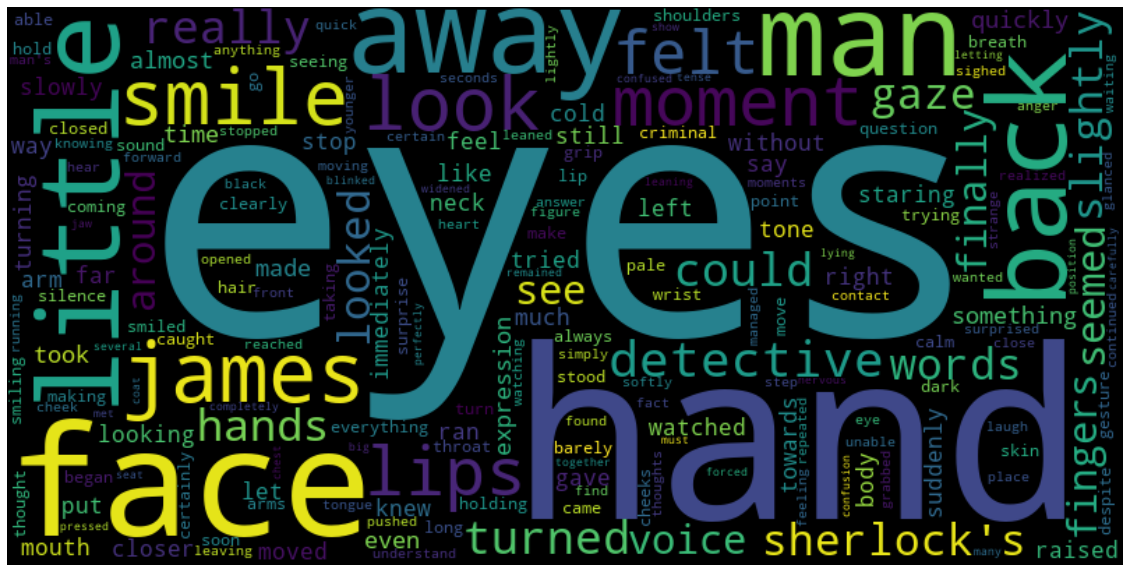

In [12]:
# create wordcloud for topic

my_topic = 0

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd

%matplotlib inline

# extract words and topic probabilities
my_words = model.topic_word.columns.tolist()
my_values = model.topic_word.values.tolist()[my_topic]

# create a dataframe with them
df = pd.DataFrame({'word': my_words,
                   'count': my_values}) 

# convert to dictionary
data = dict(zip(df['word'].tolist(), df['count'].tolist()))

# create the wordcloud
wc = WordCloud(width=800, height=400, max_words=200).generate_from_frequencies(data)

# show the wordcloud
plt.figure(figsize=(20, 20))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()